# Australian Bureau on Meterology (BOM)

- URL: http://www.bom.gov.au/
- Data Servcies: http://www.bom.gov.au/catalogue/data-feeds.shtml


In [78]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from urllib.request import urlopen, urlretrieve
from defusedxml.ElementTree import parse
from datetime import datetime
from zipfile import ZipFile
from typing import List

## Data notes

The BOM's list of Public FTP products is available at http://www.bom.gov.au/catalogue/anon-ftp.shtml

Forecast and Observation products all start with `ID` followed by a state-based key:

- IDD - NT
- IDN - NSW/ACT
- IDQ - Qld
- IDS - SA
- IDT - Tas
- IDV - Vic
- IDW - WA

Other useful links:

- [Weather words](http://www.bom.gov.au/info/wwords/)


### Observations

State Observations (all stations, with station ID), as per http://reg.bom.gov.au/catalogue/Observations-XML.pdf.

- ftp://ftp.bom.gov.au/anon/gen/fwo/IDV60920.xml – Victorian observations
- ftp://ftp.bom.gov.au/anon/gen/fwo/IDQ60920.xml – Queensland observations
- ftp://ftp.bom.gov.au/anon/gen/fwo/IDN60920.xml – New South Wales observations
- ftp://ftp.bom.gov.au/anon/gen/fwo/IDT60920.xml – Tasmanian observations
- ftp://ftp.bom.gov.au/anon/gen/fwo/IDS60920.xml – South Australian observations
- ftp://ftp.bom.gov.au/anon/gen/fwo/IDW60920.xml – Western Australian observations
- ftp://ftp.bom.gov.au/anon/gen/fwo/IDD60920.xml – Northern Territory observations
- http://www.bom.gov.au/ant/observations/antall.shtml - Antarctica

The http://www.bom.gov.au/catalogue/observations/about-weather-observations.shtml page describes the observation data.

### Forecasts

- ftp://ftp.bom.gov.au/anon/gen/fwo/IDV10753.xml – Victorian forecasts
- ftp://ftp.bom.gov.au/anon/gen/fwo/IDQ11295.xml – Queensland forecasts
- ftp://ftp.bom.gov.au/anon/gen/fwo/IDN11060.xml – New South Wales forecasts
- ftp://ftp.bom.gov.au/anon/gen/fwo/IDT16710.xml – Tasmanian forecasts
- ftp://ftp.bom.gov.au/anon/gen/fwo/IDS10044.xml – South Australian forecasts
- ftp://ftp.bom.gov.au/anon/gen/fwo/IDW14199.xml – Western Australian forecasts
- ftp://ftp.bom.gov.au/anon/gen/fwo/IDD10207.xml – Northern Territory forecasts

- QLD Forecasts
  - Precis: ftp://ftp.bom.gov.au/anon/gen/fwo/IDQ11295.xml
  - Towns: ftp://ftp.bom.gov.au/anon/gen/fwo/IDQ11296.xml
  - Cities: ftp://ftp.bom.gov.au/anon/gen/fwo/IDQ10605.xml

### Munging

The data is arranged in a very unhelpful manner. It's mainly state-based and the Product IDs don't align to stations. This means that I need to do the following for observations:

1. Download the list of stations
2. For each state/territory:
  1. Download the state summary
  2. Merge the station with the pertinent summary (based on station ID)
  
And for forecasts:

1. Download the precis forecast
2. Download the towns forecast
3. Download the cities forecast
4. Merge 1 & 2 and 1 & 3

The weather observation data is described at http://www.bom.gov.au/catalogue/observations/about-weather-observations.shtml


## Historic data

Access historic data via http://www.bom.gov.au/climate/data/stations/

Long-term stats (Brisbane Airport 040842) - http://www.bom.gov.au/clim_data/cdio/tables/text/IDCJCM0036_040842.csv

Historic (Brisbane Airport 040842):

- Rainfall: http://www.bom.gov.au/jsp/ncc/cdio/weatherData/av?p_display_type=dailyZippedDataFile&p_stn_num=040842&p_nccObsCode=136&p_c=-333724387&p_startYear=1994
- Min temps: http://www.bom.gov.au/jsp/ncc/cdio/weatherData/av?p_display_type=dailyZippedDataFile&p_stn_num=040842&p_nccObsCode=123&p_c=-333721694&p_startYear=1994
- Max temps: http://www.bom.gov.au/jsp/ncc/cdio/weatherData/av?p_display_type=dailyZippedDataFile&p_stn_num=040842&p_nccObsCode=122&p_c=-333721498&p_startYear=1994
  - HTML http://www.bom.gov.au/jsp/ncc/cdio/weatherData/av?p_nccObsCode=122&p_display_type=dailyDataFile&p_startYear=&p_c=&p_stn_num=040842
        
p_nccObsCode code values:

- 122: Maximum temperature
- 123: Minimum temperature
- 136: Rainfall 

## Station list

BOM sites use a 6-digit code, as described at http://www.bom.gov.au/climate/cdo/about/site-num.shtml. The format is `XYYnnn` where:

- `X`: defines the station series (0-5; related to station application) 
   - 0 & 1 – land-based, Bureau-managed stations;
   - 2 - official Bureau fixed off-shore sites or Island locations, and also special applications;
   - 3 - Antarctic & Sub-Antarctic land based or off-shore stations;
   - 4 - marine sites (eg. ships and buoys);
   - 5 - externally managed fixed sites.
- `YY`: station series sub-group
   - Land-based stations (series 0 & 1) = 01 to 99 (the rainfall districts);
   - Off-shore islands (series 2) = 00 to 49;
   - Special applications (series 2) = 50 to 99;
   - Antarctic & Sub-Antarctic stations (series 3) = 00 to 99;
   - Marine sites (series 4) = 00 to 99;
   - Externally managed sites (series 5) = 01 to 99 (the rainfall districts);
- `nnn`: sequential count within the above groupings (0–999)

The District (Dist) value is the rainfall district grouping, with the identifiers described in http://www.bom.gov.au/climate/cdo/about/site-num.shtml

Data URL: ftp://ftp.bom.gov.au/anon2/home/ncc/metadata/sitelists/stations.zip

In [2]:
station_url = 'ftp://ftp.bom.gov.au/anon2/home/ncc/metadata/sitelists/stations.zip'
station_download_file = 'data/bomstations.zip'

urlretrieve(station_url, station_download_file)

('data/bomstations.zip', <email.message.Message at 0x10856c668>)

In [3]:
stations_data = ''
stations_out_file = 'data/stations.txt'
with ZipFile(station_download_file) as station_zip:
    with open(stations_out_file, 'wb') as stations_file:
        stations_file.write(station_zip.read('stations.txt'))

In [4]:
station_cols = '------- ----- ---------------------------------------- ------- ------- -------- --------- -------------- --- ---------- -------- ------'

station_col_specification = []

col_start = 0

for ix, ch in enumerate(station_cols):
    if ch == ' ':
        station_col_specification.append((col_start, ix))
        col_start = ix + 1

station_col_specification.append((col_start, ix + 1))
station_col_specification        

[(0, 7),
 (8, 13),
 (14, 54),
 (55, 62),
 (63, 70),
 (71, 79),
 (80, 89),
 (90, 104),
 (105, 108),
 (109, 119),
 (120, 128),
 (129, 135)]

In [5]:
station_df = pd.read_fwf(stations_out_file, 
                           header=2,
                           na_values=['..', '.....'],
                           skip_blank_lines=True,
                           skipfooter=6,
                           colspecs=station_col_specification)

station_df.drop(index=0,inplace=True)

In [6]:
station_df.head(10)

,Site,Dist,Site name,Start,End,Lat,Lon,Source,STA,Height (m),Bar_ht,WMO
1,001000,01,KARUNJIE,1940,1983,-16.2919,127.1956,NaN,WA,320.0,NaN,NaN
2,001001,01,OOMBULGURRI,1914,2012,-15.1806,127.8456,GPS,WA,2.0,NaN,NaN
3,001002,01,BEVERLEY SP,1959,1967,-16.5825,125.4828,NaN,WA,NaN,NaN,NaN
4,001003,01,PAGO MISSION,1908,1940,-14.1331,126.7158,NaN,WA,5.0,24.4,NaN
5,001004,01,KUNMUNYA,1915,1948,-15.4167,124.7167,NaN,WA,47.0,NaN,NaN
6,001005,01,WYNDHAM PORT,1886,1995,-15.4644,128.1000,NaN,WA,20.0,NaN,NaN
7,001006,01,WYNDHAM AERO,1951,NaN,-15.5100,128.1503,GPS,WA,3.8,4.3,95214
8,001007,01,TROUGHTON ISLAND,1956,NaN,-13.7542,126.1485,GPS,WA,6.0,8.0,94102
9,001008,01,MOUNT ELIZABETH OLD SITE,1959,1978,-16.3017,126.1825,NaN,WA,640.0,NaN,NaN
10,001009,01,KURI BAY,1961,2012,-15.4875,124.5222,GPS,WA,12.0,17.0,NaN


In [7]:
station_df.tail(10)

,Site,Dist,Site name,Start,End,Lat,Lon,Source,STA,Height (m),Bar_ht,WMO
19344,300048,300,WILKINS RUNWAY WEST,2003,NaN,-66.6931,111.5039,SURVEY,ANT,727.0,NaN,89614
19345,300049,300,LAW DOME EAST,2004,2006,-66.7333,114.5000,GPS,ANT,923.0,NaN,NaN
19346,300050,300,WILKINS RUNWAY EAST,2007,NaN,-66.6831,111.5317,GPS,ANT,753.0,754.7,89615
19347,300051,300,DOME A,2005,NaN,-80.3675,77.3739,Unknown,ANT,4084.0,NaN,89577
19348,300052,300,EAGLE,2005,NaN,-76.4175,77.0297,Unknown,ANT,2824.0,NaN,89578
19349,300053,300,AM 01,2006,2010,-69.4419,71.4172,GPS,ANT,65.0,NaN,NaN
19350,300054,300,AM 02,2006,2010,-69.7133,72.6400,GPS,ANT,47.0,NaN,NaN
19351,300055,300,DAVIS (WHOOP WHOOP),2007,NaN,-68.4723,78.8735,GPS,ANT,545.0,546.5,89570
19352,300060,300,CASEY SKIWAY SOUTH,2008,NaN,-66.2803,110.7615,GPS,ANT,390.0,398.5,89809
19353,300061,NaN,BUNGER HILLS,2015,NaN,-66.2510,100.6000,GPS,ANT,12.0,16.0,89817


## Non-Pandas version

In [79]:
def read_station_file(filepath: str) -> List[str]:
    with open(filepath, 'r') as f:
        return list(f)

In [80]:
def get_column_positions(header_line: str) -> List:
    station_col_specification = []
    col_start = 0

    for ix, ch in enumerate(station_col_widths):
        if ch == ' ':
            station_col_specification.append((col_start, ix))
            col_start = ix + 1
    
    return station_col_specification

In [81]:
def get_column_names(header_text:str, column_positions:List) -> List[str]:
    station_col_headers = []
    
    for spec in column_positions:
        station_col_headers.append(header_text[spec[0]:spec[1]].strip())
        
    return station_col_headers

In [93]:
def get_records(rows:List[str], 
                column_names:List, 
                column_positions:List,
                stop_on_blank_line:bool=True, 
                data_scrubbers:List=[]) -> List:
    
    result = []

    for row in rows:
        entry = row.replace("\n", "")
        if stop_on_blank_line and not entry: break

        record = {}
        for ix,spec in enumerate(column_positions):
            record[column_names[ix]] = entry[spec[0]:spec[1]].strip()

        for col in data_scrubbers:
            if col in record:
                record[col] = data_scrubbers[col](record[col])
            
        result.append(record)
        
    return result

In [106]:
# Now try to read in without Pandas
station_list = read_station_file(stations_out_file)
station_col_specification = get_column_positions(station_list[3].replace("\n",""))
station_col_headers = get_column_names(station_list[2].replace("\n",""), station_col_specification)

scrubbers = {
    'Source': lambda val: val.replace('.',''),
    'Bar_ht': lambda val: val.replace('.',''),
    'Lat': lambda val: float(val),
    'Lon': lambda val: float(val),
    'Height (m)': lambda val: float(val.replace('..','0'))
}

station_list_clean = get_records(
    rows=station_list[4:],
    column_names=station_col_headers,
    column_positions=station_col_specification,
    data_scrubbers=scrubbers
)

In [107]:
station_list_clean

[{'Site': '001000',
  'Dist': '01',
  'Site name': 'KARUNJIE',
  'Start': '1940',
  'End': '1983',
  'Lat': -16.2919,
  'Lon': 127.1956,
  'Source': '',
  'STA': 'WA',
  'Height (m)': 320.0,
  'Bar_ht': ''},
 {'Site': '001001',
  'Dist': '01',
  'Site name': 'OOMBULGURRI',
  'Start': '1914',
  'End': '2012',
  'Lat': -15.1806,
  'Lon': 127.8456,
  'Source': 'GPS',
  'STA': 'WA',
  'Height (m)': 2.0,
  'Bar_ht': ''},
 {'Site': '001002',
  'Dist': '01',
  'Site name': 'BEVERLEY SP',
  'Start': '1959',
  'End': '1967',
  'Lat': -16.5825,
  'Lon': 125.4828,
  'Source': '',
  'STA': 'WA',
  'Height (m)': 0.0,
  'Bar_ht': ''},
 {'Site': '001003',
  'Dist': '01',
  'Site name': 'PAGO MISSION',
  'Start': '1908',
  'End': '1940',
  'Lat': -14.1331,
  'Lon': 126.7158,
  'Source': '',
  'STA': 'WA',
  'Height (m)': 5.0,
  'Bar_ht': '244'},
 {'Site': '001004',
  'Dist': '01',
  'Site name': 'KUNMUNYA',
  'Start': '1915',
  'End': '1948',
  'Lat': -15.4167,
  'Lon': 124.7167,
  'Source': '',
  'ST

In [108]:
# Now put it into pandas
station_df = pd.DataFrame(station_list_clean)
station_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19353 entries, 0 to 19352
Data columns (total 11 columns):
Bar_ht        19353 non-null object
Dist          19353 non-null object
End           19353 non-null object
Height (m)    19353 non-null float64
Lat           19353 non-null float64
Lon           19353 non-null float64
STA           19353 non-null object
Site          19353 non-null object
Site name     19353 non-null object
Source        19353 non-null object
Start         19353 non-null object
dtypes: float64(3), object(8)
memory usage: 1.6+ MB


In [109]:
station_df.head(10)

,Bar_ht,Dist,End,Height (m),Lat,Lon,STA,Site,Site name,Source,Start
0,,01,1983,320.0,-16.2919,127.1956,WA,001000,KARUNJIE,,1940
1,,01,2012,2.0,-15.1806,127.8456,WA,001001,OOMBULGURRI,GPS,1914
2,,01,1967,0.0,-16.5825,125.4828,WA,001002,BEVERLEY SP,,1959
3,244,01,1940,5.0,-14.1331,126.7158,WA,001003,PAGO MISSION,,1908
4,,01,1948,47.0,-15.4167,124.7167,WA,001004,KUNMUNYA,,1915
5,,01,1995,20.0,-15.4644,128.1000,WA,001005,WYNDHAM PORT,,1886
6,43,01,..,3.8,-15.5100,128.1503,WA,001006,WYNDHAM AERO,GPS,1951
7,80,01,..,6.0,-13.7542,126.1485,WA,001007,TROUGHTON ISLAND,GPS,1956
8,,01,1978,640.0,-16.3017,126.1825,WA,001008,MOUNT ELIZABETH OLD SITE,,1959
9,170,01,2012,12.0,-15.4875,124.5222,WA,001009,KURI BAY,GPS,1961


## Observation data

This example is for Brisbane Airport observations

In [2]:
observation_url = 'http://www.bom.gov.au/fwo/IDQ60901/IDQ60901.94578.json'
headers = {'Content-Type': 'application/json'}

response = requests.get(observation_url, headers=headers)

if response.status_code == 200:
    json_data = response.json()

In [3]:
json_data['observations']

{'notice': [{'copyright': 'Copyright Commonwealth of Australia 2018, Bureau of Meteorology. For more information see: http://www.bom.gov.au/other/copyright.shtml http://www.bom.gov.au/other/disclaimer.shtml',
   'copyright_url': 'http://www.bom.gov.au/other/copyright.shtml',
   'disclaimer_url': 'http://www.bom.gov.au/other/disclaimer.shtml',
   'feedback_url': 'http://www.bom.gov.au/other/feedback'}],
 'header': [{'refresh_message': 'Issued at  1:21 pm EST Saturday  8 September 2018',
   'ID': 'IDQ60901',
   'main_ID': 'IDQ60900',
   'name': 'Brisbane Airport',
   'state_time_zone': 'QLD',
   'time_zone': 'EST',
   'product_name': 'Capital City Observations',
   'state': 'Queensland'}],
 'data': [{'sort_order': 0,
   'wmo': 94578,
   'name': 'Brisbane Airport',
   'history_product': 'IDQ60901',
   'local_date_time': '08/01:00pm',
   'local_date_time_full': '20180908130000',
   'aifstime_utc': '20180908030000',
   'lat': -27.4,
   'lon': 153.1,
   'apparent_t': 21.4,
   'cloud': 'Partl

In [4]:
json_data['observations']['header']

[{'refresh_message': 'Issued at  1:21 pm EST Saturday  8 September 2018',
  'ID': 'IDQ60901',
  'main_ID': 'IDQ60900',
  'name': 'Brisbane Airport',
  'state_time_zone': 'QLD',
  'time_zone': 'EST',
  'product_name': 'Capital City Observations',
  'state': 'Queensland'}]

In [5]:
json_data['observations']['data'][0].keys()

dict_keys(['sort_order', 'wmo', 'name', 'history_product', 'local_date_time', 'local_date_time_full', 'aifstime_utc', 'lat', 'lon', 'apparent_t', 'cloud', 'cloud_base_m', 'cloud_oktas', 'cloud_type_id', 'cloud_type', 'delta_t', 'gust_kmh', 'gust_kt', 'air_temp', 'dewpt', 'press', 'press_qnh', 'press_msl', 'press_tend', 'rain_trace', 'rel_hum', 'sea_state', 'swell_dir_worded', 'swell_height', 'swell_period', 'vis_km', 'weather', 'wind_dir', 'wind_spd_kmh', 'wind_spd_kt'])

In [25]:
observation_df = pd.DataFrame(json_data['observations']['data'])
observation_df.loc[:, 'aifstime_utc'] = pd.to_datetime(observation_df['aifstime_utc'])
observation_df.set_index('sort_order', inplace=True)
observation_df.sort_values(by=['aifstime_utc'],inplace=True)
observation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146 entries, 145 to 0
Data columns (total 34 columns):
aifstime_utc            146 non-null datetime64[ns]
air_temp                146 non-null float64
apparent_t              146 non-null float64
cloud                   146 non-null object
cloud_base_m            134 non-null float64
cloud_oktas             134 non-null float64
cloud_type              146 non-null object
cloud_type_id           126 non-null float64
delta_t                 146 non-null float64
dewpt                   146 non-null float64
gust_kmh                146 non-null int64
gust_kt                 146 non-null int64
history_product         146 non-null object
lat                     146 non-null float64
local_date_time         146 non-null object
local_date_time_full    146 non-null object
lon                     146 non-null float64
name                    146 non-null object
press                   146 non-null float64
press_msl               146 non-null float6

In [30]:
# Check the date range
observation_df['aifstime_utc'].dt.date.drop_duplicates()

sort_order
145    2018-09-05
104    2018-09-06
54     2018-09-07
6      2018-09-08
Name: aifstime_utc, dtype: object

In [31]:
observation_df.describe()

,air_temp,apparent_t,cloud_base_m,cloud_oktas,cloud_type_id,delta_t,dewpt,gust_kmh,gust_kt,lat,lon,press,press_msl,press_qnh,rel_hum,wind_spd_kmh,wind_spd_kt,wmo
count,146.000000,146.000000,134.000000,134.000000,126.000000,146.000000,146.000000,146.000000,146.000000,1.460000e+02,146.0,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.0
mean,17.833562,16.652740,884.552239,2.268657,12.555556,2.084932,14.223288,18.184932,9.815068,-2.740000e+01,153.1,1019.022603,1019.022603,1019.091781,80.157534,13.458904,7.280822,94578.0
std,2.887076,2.636199,649.466659,2.092465,11.263076,1.287946,1.549907,9.588070,5.144804,3.564943e-15,0.0,1.842216,1.842216,1.880957,10.863218,7.317553,3.915915,0.0
min,12.000000,9.900000,300.000000,1.000000,6.000000,0.100000,10.900000,0.000000,0.000000,-2.740000e+01,153.1,1014.600000,1014.600000,1014.600000,59.000000,0.000000,0.000000,94578.0
25%,15.200000,15.225000,540.000000,1.000000,7.000000,1.000000,13.100000,11.000000,6.000000,-2.740000e+01,153.1,1017.425000,1017.425000,1017.425000,71.250000,9.000000,5.000000,94578.0
50%,18.450000,17.100000,600.000000,1.000000,7.000000,1.900000,14.100000,17.000000,9.000000,-2.740000e+01,153.1,1019.250000,1019.250000,1019.350000,81.500000,12.000000,6.500000,94578.0
75%,19.700000,18.100000,1000.000000,2.750000,8.000000,3.175000,15.650000,26.000000,14.000000,-2.740000e+01,153.1,1020.500000,1020.500000,1020.600000,89.000000,17.000000,9.000000,94578.0
max,23.500000,23.100000,3750.000000,8.000000,38.000000,4.900000,16.900000,41.000000,22.000000,-2.740000e+01,153.1,1021.900000,1021.900000,1022.000000,99.000000,33.000000,18.000000,94578.0


In [32]:
observation_df.head(10)

,aifstime_utc,air_temp,apparent_t,cloud,cloud_base_m,cloud_oktas,cloud_type,cloud_type_id,delta_t,dewpt,...,sea_state,swell_dir_worded,swell_height,swell_period,vis_km,weather,wind_dir,wind_spd_kmh,wind_spd_kt,wmo
sort_order,,,,,,,,,,,,,,,,,,,,,
145,2018-09-05 03:30:00,19.0,16.1,Mostly clear,510.0,1.0,Stratus,7.0,4.4,10.9,...,-,-,None,None,10,-,ESE,17,9,94578
144,2018-09-05 04:00:00,19.3,16.9,Mostly clear,510.0,1.0,Stratus,7.0,4.3,11.4,...,-,-,None,None,10,-,ESE,15,8,94578
143,2018-09-05 04:30:00,19.3,16.5,Mostly clear,540.0,1.0,Stratus,7.0,3.5,13.1,...,-,-,None,None,10,Showers,ESE,20,11,94578
142,2018-09-05 05:00:00,18.6,15.0,Partly cloudy,300.0,5.0,-,38.0,3.8,11.7,...,-,-,None,None,25,Distant precip.,ESE,22,12,94578
141,2018-09-05 05:30:00,19.2,16.3,Mostly clear,510.0,1.0,Stratus,7.0,3.9,12.2,...,-,-,None,None,10,Showers,ESE,19,10,94578
140,2018-09-05 06:00:00,18.8,16.5,Mostly clear,450.0,1.0,Stratus,7.0,3.8,11.9,...,-,-,None,None,10,-,ESE,15,8,94578
139,2018-09-05 06:30:00,16.8,14.9,Mostly clear,600.0,2.0,Cumulus,8.0,2.1,13.0,...,-,-,None,None,10,Showers,E,15,8,94578
138,2018-09-05 07:00:00,17.2,16.3,Mostly clear,540.0,1.0,Cumulus,8.0,2.6,12.5,...,-,-,None,None,10,-,E,9,5,94578
137,2018-09-05 07:30:00,16.7,15.9,Mostly clear,540.0,1.0,Cumulus,8.0,2.1,12.9,...,-,-,None,None,10,-,ESE,9,5,94578


<Figure size 432x288 with 0 Axes>

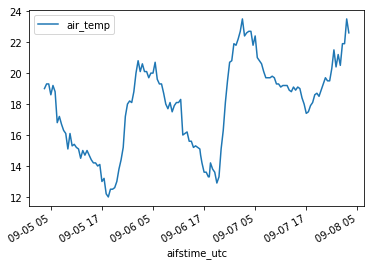

In [33]:
plt.figure()
observation_df.plot(x='aifstime_utc',y='air_temp')

## Forecasts

This example is for the Brisbane area

In [35]:
forecast_url = 'ftp://ftp.bom.gov.au/anon/gen/fwo/IDQ10095.xml'

In [37]:
with urlopen(forecast_url) as response:
    forecast_xml_data = parse(response)

In [38]:
issue_time_val = forecast_xml_data.find('./amoc/issue-time-local').text
update_time_val = forecast_xml_data.find('./amoc/next-routine-issue-time-local').text

In [39]:
# Unfortunately the UTC offset is presented as +10:00 and it's only
# as of Python 3.7 that %z can handle the colon

date_format: str = '%Y-%m-%dT%H:%M:%S%z'
current_issue = datetime.strptime(issue_time_val[:-3] + issue_time_val[-2:], date_format)
next_issue = datetime.strptime(update_time_val[:-3] + update_time_val[-2:], date_format)

print(f"Current issue: {current_issue}")
print(f"Next issue: {next_issue}")

Current issue: 2018-09-08 11:20:06+10:00
Next issue: 2018-09-08 16:20:00+10:00


In [44]:
forecast_data_areas = forecast_xml_data.findall('./forecast/area')

In [88]:
def extract_xml_text(element, default = ''):
    return element.text if element is not None else default

In [102]:
forecast_data = []

for area in forecast_data_areas:
    aac = area.attrib['aac']
    location = area.attrib['description']
    forecasts = area.findall('./forecast-period')
    for entry in forecasts:
        #entry_index = entry.attrib['index']
        
        forecast_el = entry.find('./text[@type="forecast"]')
        precis_el = entry.find('./text[@type="precis"]')
        fire_danger_el = entry.find('./text[@type="fire_danger"]')
        uv_alert_el = entry.find('./text[@type="uv_alert"]')
        
        probability_of_precipitation_el = entry.find('./text[@type="probability_of_precipitation"]')
        precipitation_range_el = entry.find('./element[@type="precipitation_range"]')
        forecast_icon_code_el = entry.find('./element[@type="forecast_icon_code"]')
        air_temperature_maximum_el = entry.find('./element[@type="air_temperature_maximum"]')
        air_temperature_minimum_el = entry.find('./element[@type="air_temperature_minimum"]')
        
        forecast_data.append({
            'aac': aac,
            'location': location,
            'start-time-utc': entry.attrib['start-time-utc'],
            'end-time-utc': entry.attrib['end-time-utc'],
            'start-time-local': entry.attrib['start-time-local'],
            'end-time-local': entry.attrib['end-time-local'],
            'forecast': extract_xml_text(forecast_el),
            'precis': extract_xml_text(precis_el),
            'fire_danger': extract_xml_text(fire_danger_el),
            'uv_alert': extract_xml_text(uv_alert_el),
            'probability_of_precipitation': extract_xml_text(probability_of_precipitation_el),
            'precipitation_range': extract_xml_text(precipitation_range_el),
            'forecast_icon_code': extract_xml_text(forecast_icon_code_el),
            'air_temperature_maximum': extract_xml_text(air_temperature_maximum_el),
            'air_temperature_maximum_units': air_temperature_maximum_el.attrib['units'] 
                if air_temperature_maximum_el is not None else '',
            'air_temperature_minimum': extract_xml_text(air_temperature_minimum_el),
            'air_temperature_minimum_units': air_temperature_minimum_el.attrib['units'] 
                if air_temperature_minimum_el is not None else '',
        })
    

In [103]:
forecast_df = pd.DataFrame(forecast_data)
forecast_df.head(10)

,aac,air_temperature_maximum,air_temperature_maximum_units,air_temperature_minimum,air_temperature_minimum_units,end-time-local,end-time-utc,fire_danger,forecast,forecast_icon_code,location,precipitation_range,precis,probability_of_precipitation,start-time-local,start-time-utc,uv_alert
0,QLD_FA001,,,,,2018-09-08T11:20:06+10:00,2018-09-08T01:20:06Z,,,,Queensland,,,,2018-09-08T11:20:06+10:00,2018-09-08T01:20:06Z,
1,QLD_ME001,,,,,2018-09-09T00:00:00+10:00,2018-09-08T14:00:00Z,High,Mostly cloudy. Medium (50%) chance of showers ...,,Brisbane,,,,2018-09-08T00:00:00+10:00,2018-09-07T14:00:00Z,"Sun protection 8:30am to 2:40pm, UV Index pred..."
2,QLD_ME001,,,,,2018-09-10T00:00:00+10:00,2018-09-09T14:00:00Z,,Sunny. Light winds becoming southwesterly 15 t...,,Brisbane,,,,2018-09-09T00:00:00+10:00,2018-09-08T14:00:00Z,
3,QLD_ME001,,,,,2018-09-11T00:00:00+10:00,2018-09-10T14:00:00Z,,Sunny. Light winds becoming southeasterly 15 t...,,Brisbane,,,,2018-09-10T00:00:00+10:00,2018-09-09T14:00:00Z,
4,QLD_ME001,,,,,2018-09-12T00:00:00+10:00,2018-09-11T14:00:00Z,,Mostly sunny. Light winds becoming southeaster...,,Brisbane,,,,2018-09-11T00:00:00+10:00,2018-09-10T14:00:00Z,
5,QLD_ME001,,,,,2018-09-13T00:00:00+10:00,2018-09-12T14:00:00Z,,Mostly sunny. Light winds becoming northeaster...,,Brisbane,,,,2018-09-12T00:00:00+10:00,2018-09-11T14:00:00Z,
6,QLD_ME001,,,,,2018-09-14T00:00:00+10:00,2018-09-13T14:00:00Z,,Sunny day. Slight (30%) chance of a shower lat...,,Brisbane,,,,2018-09-13T00:00:00+10:00,2018-09-12T14:00:00Z,
7,QLD_ME001,,,,,2018-09-15T00:00:00+10:00,2018-09-14T14:00:00Z,,Partly cloudy. Medium (40%) chance of showers....,,Brisbane,,,,2018-09-14T00:00:00+10:00,2018-09-13T14:00:00Z,
8,QLD_PT001,25,Celsius,,,2018-09-09T00:00:00+10:00,2018-09-08T14:00:00Z,,,16,Brisbane,,Shower or two. Possible storm.,50%,2018-09-08T11:15:04+10:00,2018-09-08T01:15:04Z,
9,QLD_PT001,27,Celsius,12,Celsius,2018-09-10T00:00:00+10:00,2018-09-09T14:00:00Z,,,1,Brisbane,,Sunny.,5%,2018-09-09T00:00:00+10:00,2018-09-08T14:00:00Z,


# Historic data